## This notebook uses a neural network in an attempt to classify player's by their position, based on their stats.

The goal is to be able to create a **"generalist"** model, which is trained on the full dataset of 43 seasons of NBA, and then create a series **"specialist"** models, which are initialized with the generalist's weights, but then train for a few more iterations on each specific season.

In the end, we are able to retrieve the "output" weights, which are the embeddings we are looking for. These are the weights that enter the final layer of the NN, right before making the classifications.

The goal is to get these embeddings and group them, using some form of dimensionality reduction and/or clustering algorithms, and, based on these embeddings, guess what seasons are most similar to each other, and how much time proximity actually matters.

Establishing the most similar seasons, we will run another classifier (Random Forest, *RandomForestClassificationSeasonsClusters.ipynb*), and check whether embeddings-proximity works better than time-proximity.

In [2]:
from UtilFunctions import format_season
import torch
import torch.nn as nn
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
position_to_number = {
    "PG": 0,
    "SG": 1,
    "SF": 2,
    "PF": 3,
    "C": 4
}

In [29]:
def pre_process(seasons):
    """
    This function preprocesses player statistics data for given season.
    It filters players that don't have enough data, and only keeps the most relevant statistics in terms of classification.

    Parameters:
    seasons (list): List of seasons to preprocess data for.

    Returns:
    pd.DataFrame: A DataFrame containing preprocessed player statistics for the given seasons.
    """
    df = None
    for season in seasons:
        cols_to_keep = ['Player', 'Pos', 'Tm', 'TRB%', 'AST%', 'DRB%', 'ORB%', 'BLK%', '3PAr', '3PA', 'TOV%', 'STL%', 'PF', 'FGA', 'DBPM', '3P%', 'PTS', 'FTr']
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if season > 1997:
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            #Merge, but make sure to not include the columns that would be duplicated
            player_data = player_data.merge(shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', '3PAr', '2P%', '3P%'])], on=['Player', 'Tm'])    
        
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset='Player', keep='first')
        player_data.reset_index(inplace=True)
        player_data = player_data[cols_to_keep]
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
        
        df.reset_index(inplace=True)
        df.drop(columns=['index'], inplace=True)
    return df

# Train base model

## Generate train/test split

In [5]:
def generate_train_test_split(seasons):
    """
    Split data from a list of seasons into training and testing sets.
    
    Parameters:
    seasons (list): List of seasons to split data for.
    
    Returns:
    torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor: Training features, Training target, Testing features, Testing target
    """
    
    #Pre process data and select features/target
    df = pre_process(seasons)
    X = df.loc[:, ~df.columns.isin(['Player', 'Pos', 'Tm'])]
    y = df['Pos']
    
    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
    
    #Convert target to numerical values
    y_train = [position_to_number[y] for y in y_train.values]
    y_test = [position_to_number[y] for y in y_test.values]
    
    #Convert data to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = generate_train_test_split(range(1980, 2023))

In [7]:
_, n_features = X_train.shape

## Build model with 6 linear layers and ReLU activation

In [8]:
model = nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(n_features, 512)),
    ('relu1', nn.ReLU()),
    ('dense2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('dense3', nn.Linear(256, 128)),
    ('relu3', nn.ReLU()),
    ('dense4', nn.Linear(128, 64)),
    ('relu4', nn.ReLU()),
    ('dense5', nn.Linear(64, 32)),
    ('relu5', nn.ReLU()),
    ('dense6', nn.Linear(32, 16)),
    ('relu6', nn.ReLU()),
    ('output', nn.Linear(16, 5))
]))

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
#Define number of times the base model should run
n_epochs = 1200

## Run the model, printing the loss at each 100 epochs

In [12]:
for epoch in range(n_epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Early stopping, avoid overfitting
    if loss.item() < 0.15:
        break
    if epoch % 100 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

Epoch 0 - Loss: 1.6179
Epoch 100 - Loss: 0.6979
Epoch 200 - Loss: 0.6333
Epoch 300 - Loss: 0.5613
Epoch 400 - Loss: 0.6680
Epoch 500 - Loss: 0.4858
Epoch 600 - Loss: 0.3303
Epoch 700 - Loss: 0.4315
Epoch 800 - Loss: 0.2857


In [13]:
#Chech the accuracy of the model
with torch.no_grad():
    y_pred = model(X_test)
    _, preds = torch.max(y_pred, 1)
    print(accuracy_score(preds, y_test))

0.63841547673883


# Define a model to specialize the model to each season

In [14]:
def run_specialist_model(base_model, season, n_epochs):
    """
    Runs a model that specializes in predicting player positions for a given season.
    
    Parameters:
    base_model (nn.Module): The base model to specialize from.
    season (int): The season to specialize for.
    n_epochs (int): The number of epochs to train the model for.
    
    Returns:
    float, np.ndarray: The accuracy of the model, the weights of the output layer of the model.
    """
    specialist_model = nn.Sequential(OrderedDict([
        ('dense1', nn.Linear(n_features, 512)),
        ('relu1', nn.ReLU()),
        ('dense2', nn.Linear(512, 256)),
        ('relu2', nn.ReLU()),
        ('dense3', nn.Linear(256, 128)),
        ('relu3', nn.ReLU()),
        ('dense4', nn.Linear(128, 64)),
        ('relu4', nn.ReLU()),
        ('dense5', nn.Linear(64, 32)),
        ('relu5', nn.ReLU()),
        ('dense6', nn.Linear(32, 16)),
        ('relu6', nn.ReLU()),
        ('output', nn.Linear(16, 5))
    ]))
    
    #Initialize the model with the generalist model's weights
    specialist_model.load_state_dict(base_model.state_dict())
    
    #Generate the training and testing data
    X_train, X_test, y_train, y_test = generate_train_test_split([season])
    
    #Declare optimizer and loss function
    optimizer = torch.optim.Adam(specialist_model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    #Train the model
    for epoch in range(n_epochs):
        y_pred = specialist_model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}")
    
    #Check the accuracy of the model
    with torch.no_grad():
        y_pred_sp = specialist_model(X_test)
        _, preds = torch.max(y_pred_sp, 1)
        accuracy = accuracy_score(preds, y_test)  

    return accuracy, specialist_model.output.weight.detach().numpy()

In [15]:
def run_specialist_by_season(base_model, seasons, n_epochs):
    accuracies = {}
    embeddings = {}
    for season in seasons:
        accuracy, embedding = run_specialist_model(base_model, season, n_epochs)
        accuracies[season] = accuracy
        embeddings[season] = embedding
    return accuracies, embeddings

In [16]:
accuracies, embeddings = run_specialist_by_season(model, range(1980, 2023), 100)

Epoch 0 - Loss: 0.5616
Epoch 0 - Loss: 0.7779
Epoch 0 - Loss: 0.6851
Epoch 0 - Loss: 0.6201
Epoch 0 - Loss: 0.6276
Epoch 0 - Loss: 0.4912
Epoch 0 - Loss: 0.6015
Epoch 0 - Loss: 0.1823
Epoch 0 - Loss: 0.2742
Epoch 0 - Loss: 0.6656
Epoch 0 - Loss: 0.6163
Epoch 0 - Loss: 0.5247
Epoch 0 - Loss: 0.4737
Epoch 0 - Loss: 1.0445
Epoch 0 - Loss: 0.4017
Epoch 0 - Loss: 0.3268
Epoch 0 - Loss: 0.7015
Epoch 0 - Loss: 0.7230
Epoch 0 - Loss: 0.5077
Epoch 0 - Loss: 1.1312
Epoch 0 - Loss: 0.5148
Epoch 0 - Loss: 0.4376
Epoch 0 - Loss: 0.6493
Epoch 0 - Loss: 0.7126
Epoch 0 - Loss: 0.4912
Epoch 0 - Loss: 0.5157
Epoch 0 - Loss: 0.3903
Epoch 0 - Loss: 0.4733
Epoch 0 - Loss: 0.5965
Epoch 0 - Loss: 0.7248
Epoch 0 - Loss: 0.6380
Epoch 0 - Loss: 0.6247
Epoch 0 - Loss: 0.3369
Epoch 0 - Loss: 0.5773
Epoch 0 - Loss: 0.6575
Epoch 0 - Loss: 0.6882
Epoch 0 - Loss: 0.7700
Epoch 0 - Loss: 0.8543
Epoch 0 - Loss: 0.5226
Epoch 0 - Loss: 0.4239
Epoch 0 - Loss: 1.0403
Epoch 0 - Loss: 0.6468
Epoch 0 - Loss: 1.4155


In [17]:
def find_number_of_clusters_with_silhouette(data, clusters_range):
    silhouette_avg = []
    for n in clusters_range: 
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=35)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(data, cluster_labels))

    return np.argmax(silhouette_avg) + clusters_range[0]

In [18]:
embeddings_array = np.array([embeddings[season].flatten() for season in embeddings.keys()])
embeddings_array = embeddings_array / np.linalg.norm(embeddings_array, axis=1, keepdims=True)


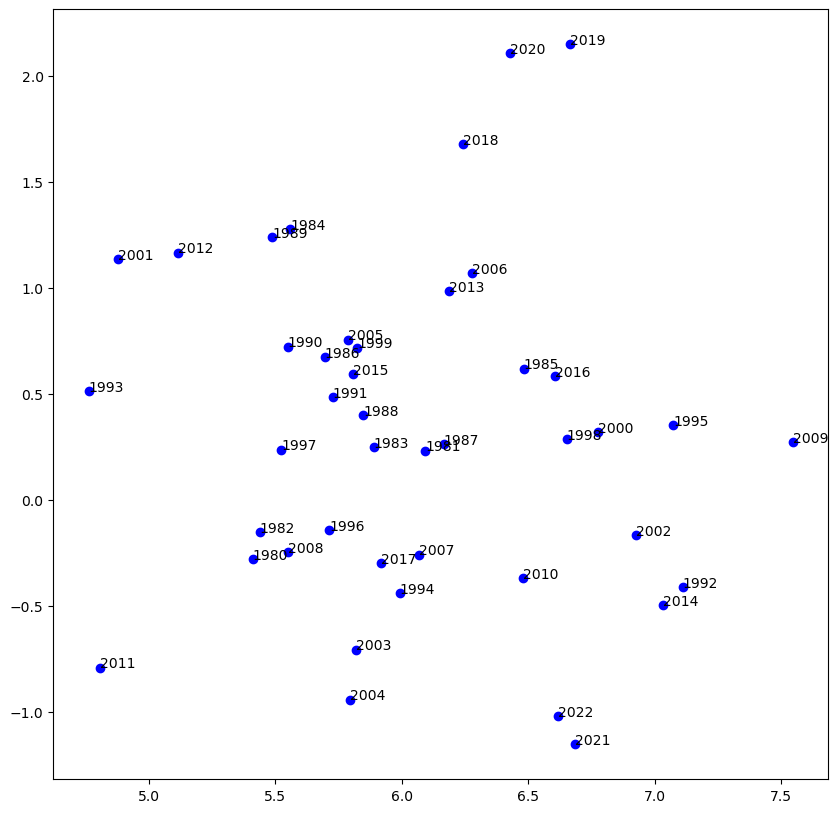

In [19]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(10, 10))
for i, season in enumerate(embeddings.keys()):
    plt.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], label=season, c='b')
    plt.text(embeddings_tsne[i, 0], embeddings_tsne[i, 1], season)

plt.show() 

In [27]:
from scipy.spatial.distance import cdist

distances = cdist(embeddings_tsne, embeddings_tsne, metric='euclidean')

closest_points = {}
for i, season in enumerate(embeddings.keys()):
    dist = distances[i]
    # Get the indices of the 8 closest points (excluding the point itself)
    closest_indices = np.argsort(dist)[1:9]
    
    closest_seasons = [list(embeddings.keys())[i] for i in closest_indices]
    closest_points[season] = closest_seasons
    
df = pd.DataFrame(closest_points)
df.to_csv("closest_seasons.csv", index=False)

### Clustering with PCA and Kmeans

c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mathe\AppData\Local\Temp\ipykernel_20620\1781175031.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2', 7)


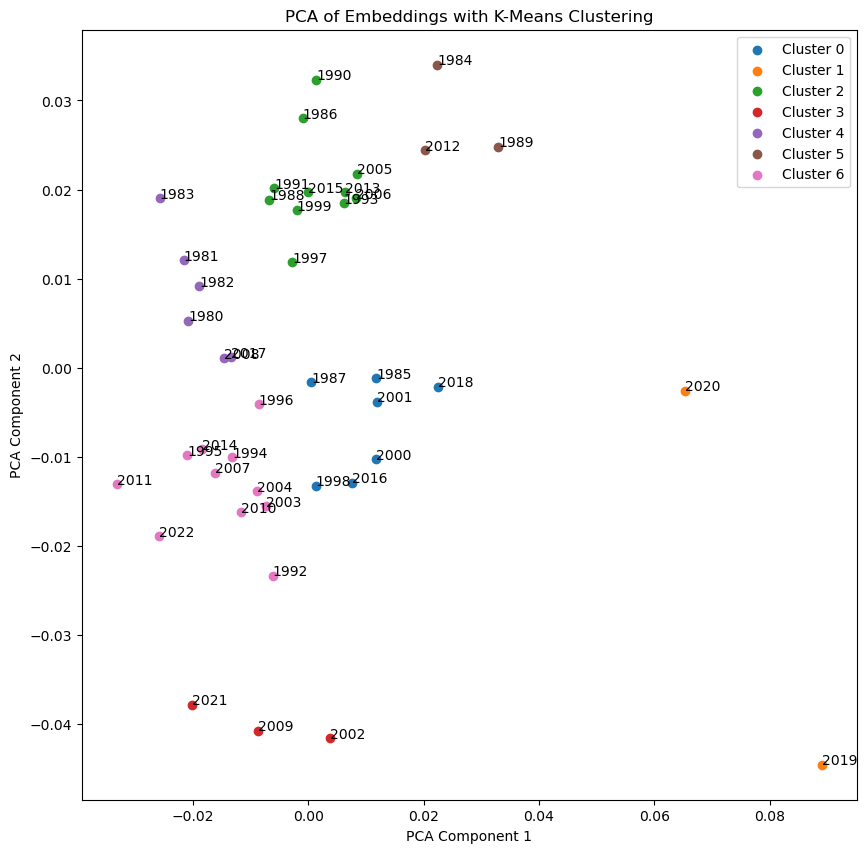

In [21]:
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_array)

kmeans = KMeans(n_clusters=7, random_state=42, n_init=35)
kmeans.fit(embeddings_pca)
cmap = plt.cm.get_cmap('Dark2', 7)

# Plotting
plt.figure(figsize=(10, 10))
for i in range(7):
    cluster_points = embeddings_pca[kmeans.labels_ == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
    for j, season in enumerate(embeddings.keys()):
        if kmeans.labels_[j] == i:
            plt.text(embeddings_pca[j, 0], embeddings_pca[j, 1], season)

plt.legend()
plt.title('PCA of Embeddings with K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### Hierearchical clustering

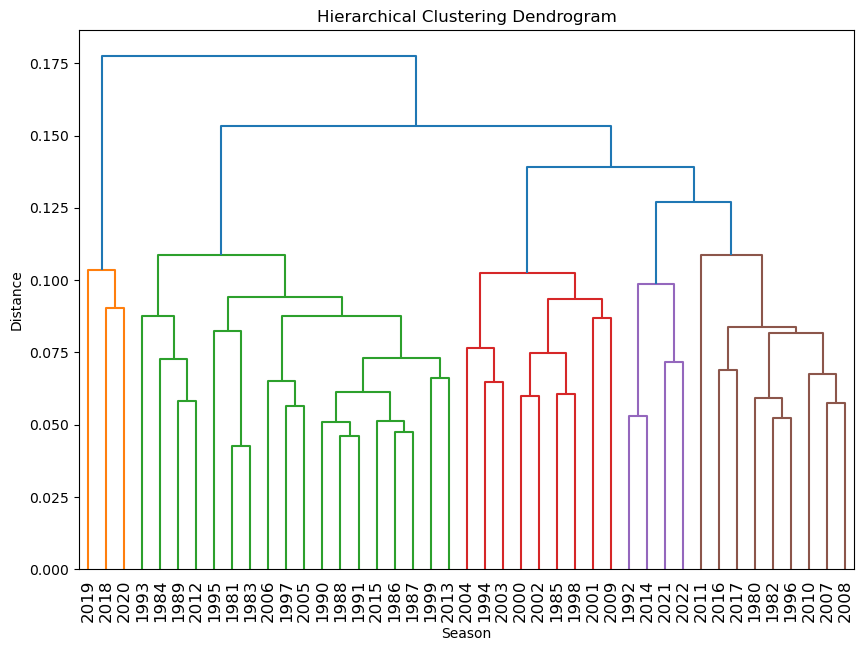

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

seasons = list(embeddings.keys())
embeddings_array = np.array([embeddings[season].flatten() for season in seasons])

embeddings_array = embeddings_array / np.linalg.norm(embeddings_array, axis=1, keepdims=True)

Z = linkage(embeddings_array, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=seasons, leaf_rotation=90, leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Season')
plt.ylabel('Distance')
plt.show()